In [43]:
%matplotlib inline

import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

In [44]:
ct_test = pd.read_csv('SAT_CT_District_Participation_2012.csv') 
print(ct_test.shape)
ct_test.head()

(130, 2)


,District,Participation Rate
0,Ansonia,0.66
1,Avon,0.90
2,Berlin,0.81
3,Bethel,0.86
4,Bloomfield,0.81


In [45]:
mean_rate = ct_test['Participation Rate'].mean() #середнє

# ddof — це корекція числа ступенів вільності при розрахунку стандартного відхилення;
# для стандартного відхилення сукупності ddof=0
stdev_rate = ct_test['Participation Rate'].std(ddof=0) #стандартне відхилення (дисперсія)

In [46]:
print('Mean participation rate is {:.3f}'.format(mean_rate))  #середнє
print('Standard deviation is {:.3f}'.format(stdev_rate))  #стандартне відхилення (стандартне квадратичне відхилення = корінь квадратний з дисперсії)

Mean participation rate is 0.741
Standard deviation is 0.136


#### Обчисліть z-оцінку та додайте результат до набору даних.

In [47]:
zscore_rate = ss.zscore(ct_test['Participation Rate'], ddof=0) #Обчислює z-статистику для кожного значення у вибірці відносно середнього значення вибірки та стандартного відхилення.
ct_test = ct_test.assign(zscore=zscore_rate)  #повертає новий об’єкт (копію) з новими стовпцями
ct_test.head(8)

,District,Participation Rate,zscore
0,Ansonia,0.66,-0.593779
1,Avon,0.90,1.175649
2,Berlin,0.81,0.512113
3,Bethel,0.86,0.880744
4,Bloomfield,0.81,0.512113
5,Bolton,0.85,0.807018
6,Branford,0.77,0.217209
7,Bridgeport,0.58,-1.183589


#### Тепер визначте аномалії та побудуйте результати.

In [48]:
def plot_anomaly(score_data, threshold):
    # Mask to plot values above and below threshold in different colors
    score_data = score_data.copy().sort_values(ascending=False).values  #копіюємо, сортуємо по спаданню, повертає представлення Numpy DataFrame.
    ranks = np.linspace(1, len(score_data), len(score_data)) #функція рівномірно повертає числові пробіли відносно інтервалу
    mask_outlier = (score_data < threshold)
    
    
    plt.figure(dpi=100)
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='OK schools')  # символ ~ інвертує логічну маску
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Z-score vs. school district', fontweight='bold')
    plt.xlabel('Ranked School district')
    plt.ylabel('Z-score')
    plt.show()

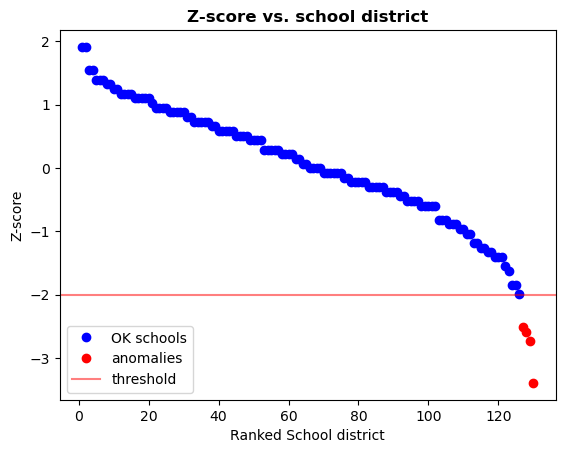

In [49]:
plot_anomaly(ct_test['zscore'], -2)

#### Нарешті, отримайте список шкіл, які є аномаліями.

In [50]:
zscore_anomalies = ct_test[(ct_test['zscore'] < -2)]
zscore_anomalies

,District,Participation Rate,zscore
50,New Britain,0.40,-2.510660
99,Windham,0.37,-2.731839
121,Eastern Connecticut Regional Educational Servi...,0.39,-2.584386
125,Stamford Academy,0.28,-3.395374


Ми знайшли свої аномалії, але нам все ще залишається зробити одне: перевірити наше припущення, що дані можна моделювати з наближенням як нормальний розподіл. Якщо це так, то ми завершили наш тест. Якщо це не так, ми не можемо пов’язати z-оцінку з імовірностями, як ми робили раніше в цьому файлі.

#### По-перше, давайте об’єднаємо дані та подивимось, як це виглядає як гістограма.

In [51]:
nbins= 20
n_hist, bins_hist, patches_hist = plt.hist(ct_test['Participation Rate'], nbins, density=False,
                           cumulative=False, linewidth=1.0, label='data')

Ця гістограма має два максимуми та зміщена вліво, тому навряд чи буде нормальною.

##### Ми також можемо порівняти кумулятивну функцію розподілу (CDF) для наших даних із CDF нормального розподілу з тим самим середнім і стандартним відхиленням наших даних.

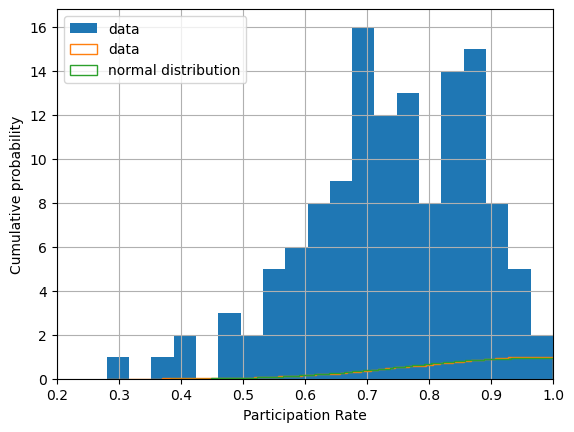

In [52]:
num_bins = 130
plt.hist(ct_test['Participation Rate'], num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='data')
normal_dist = [random.gauss(mean_rate, stdev_rate) for _ in range(500)]
plt.hist(normal_dist, num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='normal distribution')
plt.grid(True) #додати лінії сітки до графіка
plt.legend(loc='upper left')
axes = plt.gca() #Отримайте поточні осі
axes.set_xlim([0.2,1.0])
plt.xlabel('Participation Rate')
plt.ylabel('Cumulative probability')
plt.show()

Знову ж таки, ми бачимо різницю. Якби ці два візуальні тести не були вирішальними, ми могли б провести чисельний тест на нормальність (наприклад, тест Шапіро-Вілка, або інший тест).

Незважаючи на те, що наші дані не відповідають нормальному розподілу, як z-показник, так і модифікований z-показник допомогли нам визначити викиди. Таким чином, хоча ми не можемо робити жодних ймовірнісних прогнозів на основі z-показників, ми можемо з упевненістю зосередитися на цих чотирьох школах.

In [53]:
# Перший рядок – це рядок заголовка, але імена заголовків громіздкі.
# Пропустіть перший рядок (skiprows=1) і позначте вручну
# Кодування гарантує правильне відображення наголосів у самих іменах футболістів 
top_goals = pd.read_csv('world_cup_top_goal_scorers.csv', 
                        encoding='utf-8',  
                        names=['Year', 'Player(s)', 'Goals'], skiprows=1)                                                                                
top_goals

,Year,Player(s),Goals
0,1930,Guillermo Stábile,8
1,1934,Oldřich Nejedlý,5
2,1938,Leônidas,7
3,1950,Ademir,8
4,1954,Sándor Kocsis,11
5,1958,Just Fontaine,13
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4
7,1966,Eusébio,9
8,1970,Gerd Müller,10
9,1974,Grzegorz Lato,7


Знову використаємо z-оцінку для виявлення аномалій. Оскільки нас цікавлять суперзірки, цього разу у нас буде верхній поріг. Обираємо 𝑧=+2. Вище цієї z-оцінки будь-який гравець буде позначений як аномалія.

Як і раніше, ми обчислюємо середнє значення та стандартне відхилення.

In [54]:
mean_goals = top_goals['Goals'].mean()
stdev_goals = top_goals['Goals'].std(ddof=0)
print('Mean number of goals is {:.2f}'.format(mean_goals))
print('Standard deviation is {:.2f}'.format(stdev_goals))

Mean number of goals is 7.05
Standard deviation is 2.15


#### Обчисліть z-оцінку для кожного гравця та додайте результат до набору даних.

In [55]:
zscore_goals = ss.zscore(top_goals['Goals'], ddof=0)
top_goals = top_goals.assign(zscore=zscore_goals)
top_goals.head(21)

,Year,Player(s),Goals,zscore
0,1930,Guillermo Stábile,8,0.443242
1,1934,Oldřich Nejedlý,5,-0.952971
2,1938,Leônidas,7,-0.022162
3,1950,Ademir,8,0.443242
4,1954,Sándor Kocsis,11,1.839455
5,1958,Just Fontaine,13,2.770264
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4,-1.418375
7,1966,Eusébio,9,0.908647
8,1970,Gerd Müller,10,1.374051
9,1974,Grzegorz Lato,7,-0.022162


#### Тепер змініть попередню функцію побудови для відображення результатів.

In [56]:
def plot_anomaly_goals(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color='b', label='typical player')
    plt.axhline(threshold,color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('Z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player Rank')
    plt.ylabel('Z-score')
    plt.show()

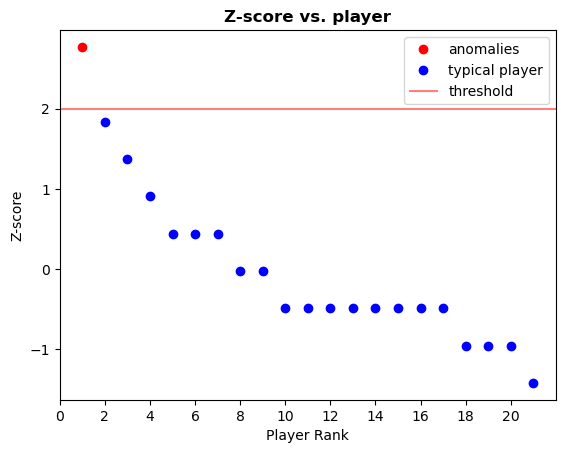

In [57]:
plot_anomaly_goals(top_goals['zscore'], 2)

Вибирається лише один гравець: Джаст Фонтейн.

In [58]:
zscore_anomalies_players = top_goals[(top_goals['zscore'] > 2)]
zscore_anomalies_players

,Year,Player(s),Goals,zscore
5,1958,Just Fontaine,13,2.770264


In [59]:
median_goals = np.median(top_goals['Goals'])
median_goals

np.float64(6.0)

In [60]:
def modified_zscore(data, consistency_correction=1.4826):
    """
    Повертає модифікований z-оцінку та середнє абсолютне відхилення (MAD) із оцінок у даних.
     Коефіцієнт поправки консистенції перетворює MAD на стандартне відхилення для даного розподілу. 
     Значення за замовчуванням (1,4826) є коефіцієнтом перетворення, якщо базові дані розподілені нормально
    """
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

#### Як і раніше, обчисліть модифікований z-рахунок для всіх гравців, а потім побудуйте та перелічіть результати. Зауважте, що поріг залишається незмінним і становить 𝑦=+2.

In [61]:
mod_zscore_goals, mad_goals = modified_zscore(top_goals['Goals'])
top_goals = top_goals.assign(mod_zscore=mod_zscore_goals)

In [62]:
def plot_anomaly_goals_2(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data > threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='typical player')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player')
    plt.ylabel('Modified z-score')
    plt.show()

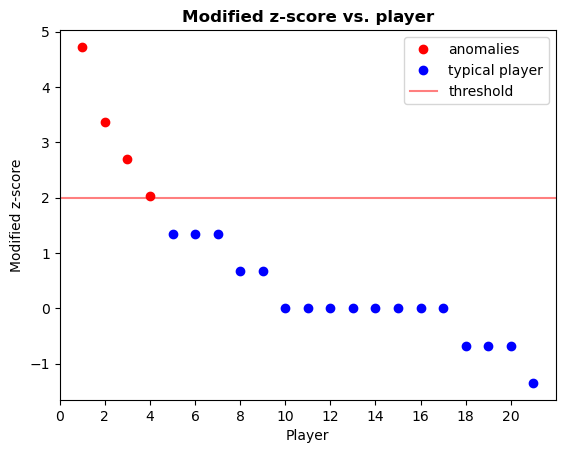

In [63]:
plot_anomaly_goals_2(top_goals['mod_zscore'], 2)

In [64]:
mod_zscore_anomalies_players = top_goals[(top_goals['mod_zscore'] > 2)]
mod_zscore_anomalies_players

,Year,Player(s),Goals,zscore,mod_zscore
4,1954,Sándor Kocsis,11,1.839455,3.372454
5,1958,Just Fontaine,13,2.770264,4.721435
7,1966,Eusébio,9,0.908647,2.023472
8,1970,Gerd Müller,10,1.374051,2.697963


Тепер ми знаходимо чотирьох аномальних гравців.

##### Запитання: Як MAD порівнюється зі стандартним відхиленням, розрахованим раніше?

##### Відповідь:

In [65]:
print('The value of MAD is {:.2f}'.format(mad_goals))
print('Standard deviation is {:.2f}'.format(stdev_goals))

The value of MAD is 1.00
Standard deviation is 2.15


In [66]:
# Define Grubbs' Test function
def grubbs_test(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    abs_z_scores = np.abs((data - mean) / std_dev)
    max_z_score = np.max(abs_z_scores)
    max_z_score_index = np.argmax(abs_z_scores)
    
    print(f"Number of data points: {n}")
    print(f"Mean of data: {mean}")
    print(f"Standard Deviation of data: {std_dev}")
    print("\nZ-Scores")
    print(z_scores)
    print(f"Max Absolute Z-Score: {max_z_score} located at index {max_z_score_index}\n")

    # Calculate the Grubbs' Test statistic
    G_calculated = (n-1) * np.sqrt(max_z_score**2 / (n-2+max_z_score**2))

    # Look up the critical value of the Grubbs' Test statistic from the t-distribution
    t_critical = ss.t.ppf(1 - alpha / (2*n), n-2)
    G_critical = ((n-1) / np.sqrt(n)) * np.sqrt(t_critical**2 / (n-2 + t_critical**2))

    # If the calculated test statistic is larger than the critical value, then reject the null hypothesis and mark the data point as an outlier
    if G_calculated > G_critical:
        print(f"Outlier detected at index {max_z_score_index}.")
        outlier = True
    else:
        print("No outliers detected.")
        outlier = False

    return max_z_score_index, outlier

In [67]:
# Call the Grubbs' Test function on our data
outlier_index, is_outlier = grubbs_test(top_goals['Goals'])

Number of data points: 21
Mean of data: 7.0476190476190474
Standard Deviation of data: 2.1486693662244725

Z-Scores
0     0.443242
1    -0.952971
2    -0.022162
3     0.443242
4     1.839455
5     2.770264
6    -1.418375
7     0.908647
8     1.374051
9    -0.022162
10   -0.487566
11   -0.487566
12   -0.487566
13   -0.487566
14   -0.487566
15   -0.487566
16    0.443242
17   -0.952971
18   -0.952971
19   -0.487566
20   -0.487566
Name: Goals, dtype: float64
Max Absolute Z-Score: 2.770263794862101 located at index 5

Outlier detected at index 5.


In [68]:
top_goals[['Player(s)','Goals']].iloc[outlier_index]

Player(s)    Just Fontaine
Goals                   13
Name: 5, dtype: object

Тест Грабса також знайшов аномальне значення для футболіста Just Fontaine

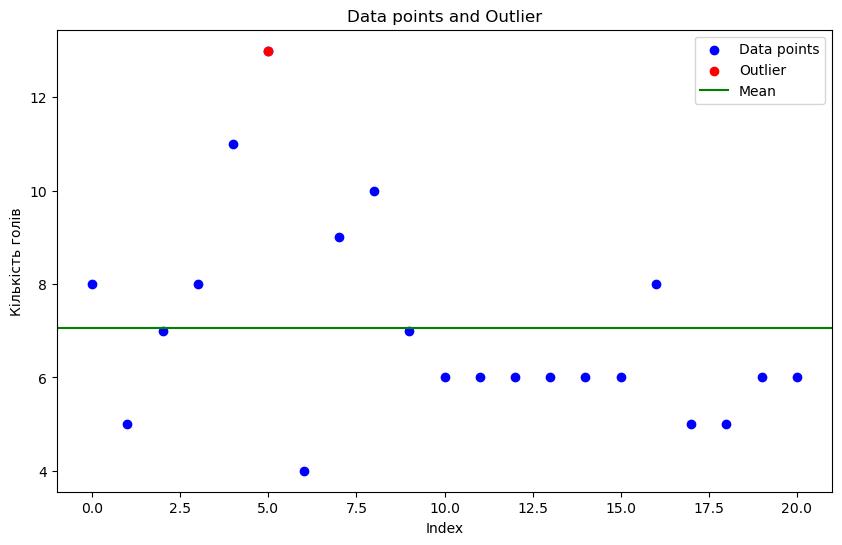

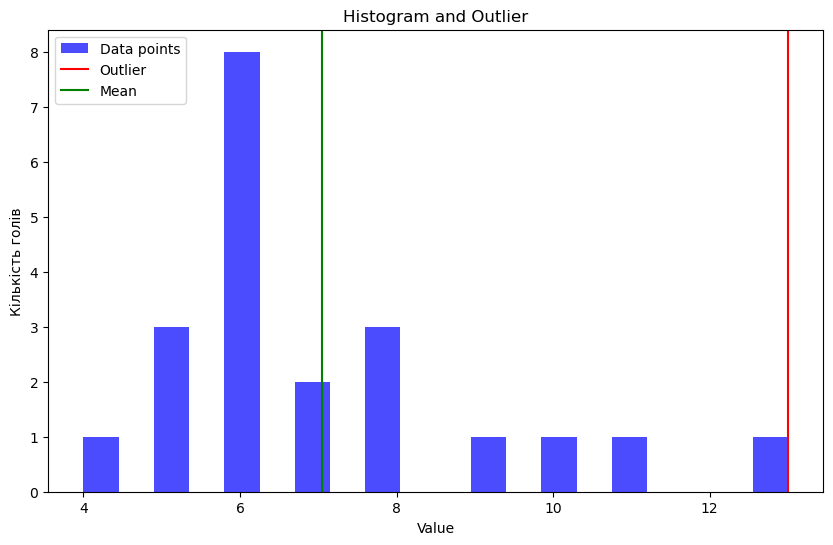

In [69]:
# Create a scatter plot of the data
plt.figure(figsize=(10, 6))
plt.scatter(range(len(top_goals['Goals'])), top_goals['Goals'], color='blue', label='Data points')
if is_outlier:
    plt.scatter(outlier_index, top_goals['Goals'][outlier_index], color='red', label='Outlier')
plt.axhline(y=np.mean(top_goals['Goals']), color='green', linestyle='-', label='Mean')
plt.legend()
plt.title('Data points and Outlier')
plt.xlabel('Index')
plt.ylabel('Кількість голів')
plt.show()

# Create a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(top_goals['Goals'], bins=20, color='blue', alpha=0.7, label='Data points')
if is_outlier:
    plt.axvline(x=top_goals['Goals'][outlier_index], color='red', linestyle='-', label='Outlier')
plt.axvline(x=np.mean(top_goals['Goals']), color='green', linestyle='-', label='Mean')
plt.legend()
plt.title('Histogram and Outlier')
plt.xlabel('Value')
plt.ylabel('Кількість голів')
plt.show()

## Виявлення багатовимірних викидів за допомогою відстані Махаланобіса¶


Відстань Махаланобіса — це міра відстані між точкою 𝑃
   і множиною 𝐷
  . Це багатовимірне узагальнення ідеї вимірювання кількості стандартних відхилень 𝑃
   від середнього 𝐷
  .

За точкою 𝑃    з координатами $(x_1, x_2, ..., x_n)$    в 𝑛
  -вимірному просторі, відстань Махаланобіса $D_M$    з 𝑃
   до центру набору точок обчислюється як:

$$
D_M = \sqrt{ (P - \mu)^T \Sigma^{-1} (P - \mu) }
$$
 
де:

𝑃
   – точковий вектор,
𝜇
   – середній вектор розподілу,
Σ
   є коваріаційною матрицею розподілу, і
𝑇
   позначає матричне транспонування.
Відстань Махаланобіса враховує кореляції набору даних і є масштабно-інваріантною. На відміну від евклідової відстані, вона враховує дисперсію та коваріацію кількох змінних.

#### Тест на відстань Махаланобіса

Відстань Махаланобіса можна використовувати в перевірці гіпотези, тесті відстані Махаланобіса, для виявлення багатофакторних викидів.

Для точок вибірки розміру 𝑛 з 𝑝 ознаками (координатами) квадрат відстані Махаланобіса $D_M^2$
 відповідає розподілу хі-квадрат із 𝑝   ступенями свободи за нульовою гіпотезою, тобто точка відповідає розподілу. Отже, якщо обчислене $D_M^2$    перевищує критичне значення розподілу хі-квадрат для бажаного рівня значущості (наприклад, 0,05), ми відхиляємо нульову гіпотезу.

Процедура перевірки гіпотези така:

1. Обчисліть відстань Махаланобіса $D_M^2$ для відповідної точки.

2. Визначте критичне значення хі-квадрат для 𝑝    ступені свободи та бажаний рівень значущості.

3. Якщо $D_M^2$   > критичного значення,тоді  точка вважається викидом.

Цей тест може бути дуже корисним на практиці для виявлення викидів у багатовимірних даних.

In [70]:
from scipy.stats import chi2
from sklearn.covariance import EmpiricalCovariance

In [71]:
# Визначте багатовимірні дані
data = np.array([[100000, 16000, 300, 60, 76],
                 [800000, 60000, 400, 88, 89],
                 [650000, 300000, 1230, 90, 89],
                 [700000, 10000, 300, 87, 57],
                 [860000, 252000, 400, 83, 79],
                 [730000, 350000, 104, 81, 84],
                 [400000, 260000, 632, 72, 78],
                 [20, 260000, 6302, 2, 2000],
                 [870000, 510000, 221, 91, 99],
                 [780000, 2000, 142, 90, 97],
                 [400000, 5000, 267, 93, 99]])

# Create a DataFrame
columns = ['Price', 'Distance', 'Emission', 'Performance', 'Mileage']
df = pd.DataFrame(data, columns=columns)

print(f"Data:\n{df}\n")

Data:
     Price  Distance  Emission  Performance  Mileage
0   100000     16000       300           60       76
1   800000     60000       400           88       89
2   650000    300000      1230           90       89
3   700000     10000       300           87       57
4   860000    252000       400           83       79
5   730000    350000       104           81       84
6   400000    260000       632           72       78
7       20    260000      6302            2     2000
8   870000    510000       221           91       99
9   780000      2000       142           90       97
10  400000      5000       267           93       99



In [72]:
def calculateMahalanobis(data):
    robust_cov = EmpiricalCovariance().fit(data)
    m_dist = robust_cov.mahalanobis(data)
    return m_dist

In [73]:
# Обчисліть відстані Махаланобіса
m_dist = calculateMahalanobis(df)

print(f"Відстані Махаланобіса:\n{m_dist}\n")

# Визначте рівень значущості для виявлення викидів
alpha = 0.10

# Cобчислити порогове значення (на основі розподілу хі-квадрат)
thresh = chi2.ppf(1 - alpha, df=df.shape[1])

print(f"Поріг для виявлення викидів: {thresh}\n")

# Виявлення викидів (де відстань Махаланобіса перевищує порогове значення)
outliers = df[m_dist > thresh]
df['distance'] = m_dist
df['outlier'] = df['distance'] > thresh

print(f"Аномалії:\n{outliers}")

print(f"Дані:\n{df}\n")

Відстані Махаланобіса:
[7.23782241 2.22109829 8.21440824 1.89413229 2.57169465 2.83641857
 2.70941648 9.99763797 6.10733273 3.03153561 8.17850277]

Поріг для виявлення викидів: 9.236356899781123

Аномалії:
   Price  Distance  Emission  Performance  Mileage
7     20    260000      6302            2     2000
Дані:
     Price  Distance  Emission  Performance  Mileage  distance  outlier
0   100000     16000       300           60       76  7.237822    False
1   800000     60000       400           88       89  2.221098    False
2   650000    300000      1230           90       89  8.214408    False
3   700000     10000       300           87       57  1.894132    False
4   860000    252000       400           83       79  2.571695    False
5   730000    350000       104           81       84  2.836419    False
6   400000    260000       632           72       78  2.709416    False
7       20    260000      6302            2     2000  9.997638     True
8   870000    510000       221        

# Вправа №1¶
Ця вправа стосується рівня участі в SAT.

A. Повторіть аналіз, використовуючи модифіковану z-оцінку.

Б. Повторіть аналіз, використовуючи тест Граббса. Застосуйте тест Граббса чотири рази, видаляючи на кожному кроці рядок даних з аномалією.

С. Ви знаходите однакові аномалії? Порівняйте знайдені аномалії, які отрмали при застосуванні z-оцінки, модифікованої z-оцінки, тесту Граббса.

D. Зробіть свої висновки.

#### Розв'язок #1

In [82]:
import numpy as np

def z_score_outliers(data, threshold=3):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    return np.where(np.abs(z_scores) > threshold)

# Приклад даних
data = pd.read_csv('SAT_CT_District_Participation_2012.csv')

# Обчислення модифікованої z-оцінки
participation_rate = data['Participation Rate']

# Застосовуємо Z-оцінку
z_outliers = z_score_outliers(participation_rate)

# Визначення аномалій (поріг 3)
print("Аномалії за допомогою Z-оцінки:")
print(data.iloc[z_outliers[0]])

Аномалії за допомогою Z-оцінки:
             District  Participation Rate
125  Stamford Academy                0.28


In [83]:
from scipy import stats

# Функція для застосування тесту Граббса
def grubbs_test(data, alpha=0.05):
    outliers = []
    data = np.sort(data)
    n = len(data)
    G = (data[-1] - data[0]) / np.std(data)
    critical_value = stats.t.ppf(1 - alpha / (2 * n), n - 2)
    
    while G > critical_value:
        outliers.append(data[-1]) 
        data = data[:-1] 
        G = (data[-1] - data[0]) / np.std(data)
    return outliers

# Виконання тесту Граббса
grubbs_outliers = grubbs_test(participation_rate)
print("Anomalies based on Grubbs test:", grubbs_outliers)


Anomalies based on Grubbs test: [np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.93), np.float64(0.93), np.float64(0.93), np.float64(0.92), np.float64(0.92), np.float64(0.91), np.float64(0.91), np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(0.89), np.float64(0.89), np.float64(0.89), np.float64(0.89), np.float64(0.89), np.float64(0.88), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.85), np.float64(0.85), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.83), np.float64(0.83), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.8), np.float64(0.8), np.float64(0.8), np.float64(0.8), np.float64(0.78), np.float64(0.78), np.fl

In [84]:
print("Anomalies comparison:")
print("Modified Z-score anomalies:", z_outliers)
print("Grubbs test anomalies:", grubbs_outliers)

Anomalies comparison:
Modified Z-score anomalies: (array([125]),)
Grubbs test anomalies: [np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.93), np.float64(0.93), np.float64(0.93), np.float64(0.92), np.float64(0.92), np.float64(0.91), np.float64(0.91), np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(0.89), np.float64(0.89), np.float64(0.89), np.float64(0.89), np.float64(0.89), np.float64(0.88), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.85), np.float64(0.85), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.83), np.float64(0.83), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.8), np.float64(0.8), np.float64(0.8), n